# Working with raster data

Raster data represent a matrix of cells (or pixels) organized into rows and columns (or a grid). Grid cells can represent data that changes **continuously** across a landscape (surface) such as elevation, air temperature, or . reflectance data from satellite imaging platforms. Grid cells can also represent **discrete** data such as vegetation type or land cover. 

We recommend three libraries for accessing and analyzing raster data in Python. The first is called `rasterio` which builds on the popular **Geographic Raster Abstraction Library** or `GDAL`. It supports read/write access for over 160 raster formats (e.g. GeoTIFF, NetCDF4) and includes methods for finding dataset information, reprojections, resampling, format conversion, and mosaicking. Once we have imported, resampled the data etc., we can apply fast matrix operations using `NumPy`. Finally, we may also use `xarray` which introduces labels in the form of **dimensions**, **coordinates** and **attributes** on top of raw NumPy-like arrays, a bit like `Pandas`.

```{image} images/raster_matrix.png
:alt: raster matrix
:width: 500px
:align: center
```

In this demo, we will be working with elevation data, also known as a Digital Elevation Model (DEM), of the Cascades Mountain Range that includes Mt. Rainier and Mt. Adams. The data is formatted as a `GeoTIFF` and we will open it using `rasterio` function, `open()`. This function take a **path string** and returns a **dataset object**.

In [1]:
import rasterio
import numpy as np

src = rasterio.open('data/N46W122.tif')
src

<open DatasetReader name='data/N46W122.tif' mode='r'>

````{margin}
```{note}
`src` stands for **source**
```
````

## Dataset attributes

The **dataset object** contains a number of **attributes** which can be explored using the following methods. Remember that a raster **band** is an array of values representing **a single** variable in 2D space. All bands of a dataset have the **same** number of rows and columns.

In [2]:
print(f"Number of bands: {src.count}")
print(f"Width: {src.width}")
print(f"Height: {src.height}")

Number of bands: 1
Width: 3601
Height: 3601


## Georeferencing

Like vector data, pixels in raster data can be mapped to regions on the Earth's surface. Like `GeoPandas`, we can display the **coordinate reference system** of our data using the `crs` method. 

In [3]:
src.crs

CRS.from_epsg(4326)

Now that we know our data has a WGS84 geographic projection (i.e. longitudes and latitudes), we can display the **extent** of our dataset using the `bounds` method.

In [4]:
src.bounds

BoundingBox(left=-122.00013888888888, bottom=45.999861111111116, right=-120.9998611111111, top=47.00013888888889)

Finally, we can display the  dataset's geospatial transform using the `transform` method. This function displays similar information to `bounds` but also contains the **spatial resolution** of the dataset (i.e. the dimensions that each pixel of our dataset represents on the ground). Since our dataset has a **WGS84 geographic projection** (i.e. `EPSG:4326`), the units of spatial resolution are in **degrees**. 

In [5]:
src.transform

Affine(0.0002777777777777778, 0.0, -122.00013888888888,
       0.0, -0.0002777777777777778, 47.00013888888889)

## Reading raster data

Now that we have some basic information about our data, we can go ahead and import it using the `read()` function. Data from a raster band can be accessed by the band's index number. Note that bands are indexed from 1 due to a  GDAL convention. 

In [6]:
srtm = src.read(1)

````{margin}
```{note}
`srtm` stands for the [**Shuttle Radar Topography Mission**](https://www2.jpl.nasa.gov/srtm/) which collected this elevation data. 
```
````

The read() method returns a numpy N-D array.

In [7]:
srtm

array([[ 487,  485,  484, ..., 1729, 1738, 1747],
       [ 490,  489,  488, ..., 1718, 1727, 1733],
       [ 492,  491,  490, ..., 1704, 1713, 1721],
       ...,
       [ 976,  979,  980, ..., 1111, 1113, 1116],
       [ 975,  979,  979, ..., 1111, 1113, 1116],
       [ 971,  972,  974, ..., 1112, 1114, 1116]], dtype=int16)

In [8]:
type(srtm)

numpy.ndarray

We can have a look at the data using `matplotlib`.

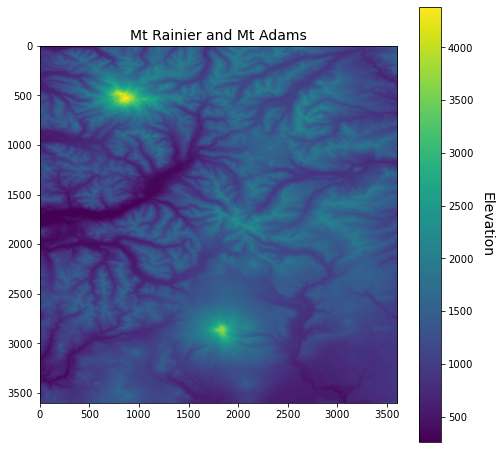

In [9]:
import matplotlib.pyplot as plt

# Plot data
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(srtm)
ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20

## Indexing

Many GIS tasks require us to read raster values at given locations. Rasterio dataset objects have an `index()` method for deriving the **array indices** corresponding to points in **georeferenced space**. 

Let's demonstrate with an example... what is the elevation of the summit of Mt Rainier? (`-121.760424, 46.852947`)

In [10]:
# Define latitude and longitude of summit
rainier_summit = [-121.760424, 46.852947]

# Find row/column in corresponding raster dataset
loc_idx = src.index(rainier_summit[0], rainier_summit[1])

print(f"Grid cell index: {loc_idx}")

Grid cell index: (529, 862)


We can use **matrix indexing** to find the value of the raster data at that location (see [Week 2 demo](../02a-demo.ipynb#Matrix-indexing-and-slicing) for reminder).

In [11]:
elevation = srtm[loc_idx]

print(f"The summit of Mt Rainier is at {int(elevation)} m or {int(elevation * 3.281)} feet")

The summit of Mt Rainier is at 4374 m or 14351 feet


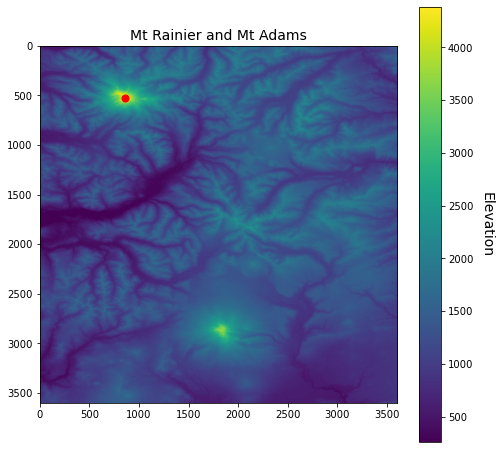

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(srtm)

# Plot a point on grid
ax.scatter(loc_idx[1], loc_idx[0], s=50, color='red')

ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20

## More indexing methods

How would we find the index of the **lowest elevation** in this raster dataset? The `NumPy` [`argmin()`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) function returns the indices of the minimum values of an array.

In [13]:
min_idx_value = srtm.argmin()
print(min_idx_value)

6060580


Wait... I thought this dataset has two dimensions... Yes but by default, `argmin()` returns the index as a flattened (1D) array. Fortunately, converting from 1D back to 2D is simple using `np.unravel_index`. 

In [14]:
low_idx = np.unravel_index(min_idx_value, srtm.shape)
print(low_idx)

(1683, 97)


In [15]:
elevation = srtm[low_idx]

print(f"The lowest elevation is {elevation} m")

The lowest elevation is 262 m


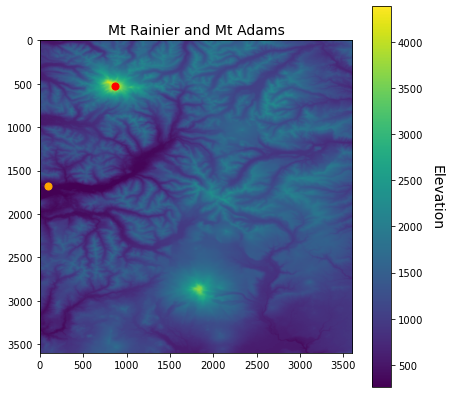

In [16]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(srtm)

# Plot a point on grid
ax.scatter(loc_idx[1], loc_idx[0], s=50, color='red')
ax.scatter(low_idx[1], low_idx[0], s=50, color='orange')

ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20

## Reprojecting

We could use `Rasterio` to reproject raster data... but it’s quite tricky!

```{image} images/rasterio_reproject.png
:alt: rasterio reproject
:width: 700px
:align: center
```

Instead we recommend using [**GDAL utilities**](https://gdal.org/programs/index.html#raster-programs). We can execute these commands in our jupyter notebook cells using the `!` sign.

To reproject our data, we can use [`gdalwarp`](https://gdal.org/programs/gdalwarp.html#gdalwarp). All we need to do is set a **target spatial reference** using the `-t_srs` flag followed by a space, the **input dataset**, and the **output dataset**. Below we set the target spatial reference to [**UTM Zone 10N**](https://epsg.io/32610) (or EPSG:32610) which is the UTM Zone for the Pacific Northwest. 

```{image} images/utm_zones.png
:alt: utm zones
:width: 300px
:align: center
```

In [17]:
!gdalwarp -t_srs EPSG:32610 data/N46W122.tif data/N46W122_utm.tif

Processing data/N46W122.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/N46W122.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


If we navigate to our `data` folder we should see a new file called `N46W122_utm.tif`. Let's `open` this new GeoTIFF and check that is has a new projection. 

In [18]:
src = rasterio.open('data/N46W122_utm.tif')
src.crs

CRS.from_epsg(32610)

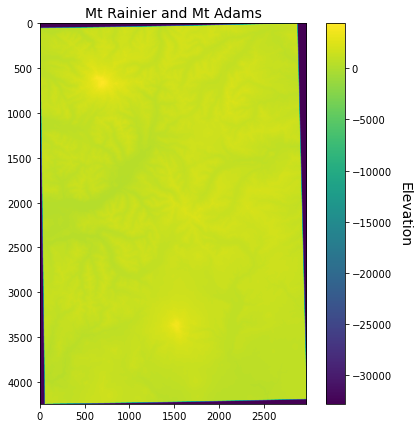

In [19]:
srtm = src.read(1)

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(srtm)

ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20

Why does the data look so strange now? Well, since we reprojected it, our data no longer represents a rectangle/square. Since all arrays have to be rectangles/squares, our reprojection introduced some **NoData values** at the edges. If we have a look at our array, we see that these NoData values are indicated by the integer `-32768` which is the smallest possible value that can be represented by the `int16` data type (i.e. -32,768 to 32,767). 

In [20]:
srtm

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

We can mask these NoData values by using NumPy's [**masked array**](https://numpy.org/doc/stable/reference/maskedarray.generic.html) module that makes it easier to deal with arrays that have missing or invalid entries.

In [21]:
srtm_masked = np.ma.masked_array(srtm, mask=(srtm == -32768))

Now when we plot the data, the NoData values are not assigned a color.`

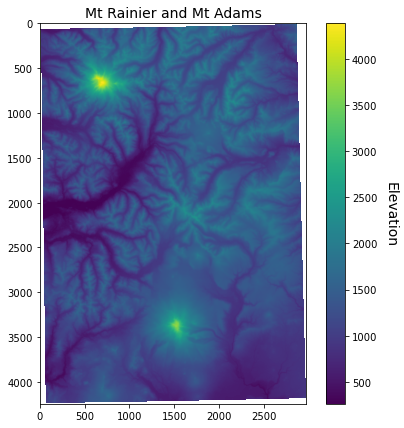

In [22]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(srtm_masked)

ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20

## Resampling

GDAL utilites make it straightforward to change the **spatial resolution** of our raster dataset. To reduce the pixel size of our dataset from around 30 m to 1,000 m can be carried out using `gdalwarp`. This time, however, we specify the `-tr` flag, which stands for **target resolution**, followed by the pixel size we want.

In [25]:
!gdalwarp -tr 1000 -1000 data/N46W122_utm.tif data/N46W122_utm_1000.tif

Creating output file that is 79P x 113L.
Processing data/N46W122_utm.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/N46W122_utm.tif.
Copying nodata values from source data/N46W122_utm.tif to destination data/N46W122_utm_1000.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Now when we `open`, `read`, `mask`, and `plot` our data, we will see that it looks a lot coarser/pixelated because  each grid cell represents 1 km on the ground.

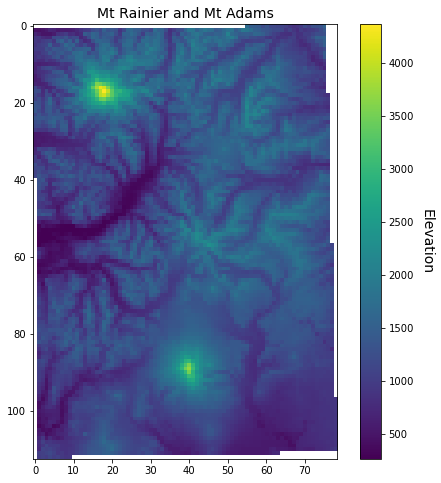

In [26]:
# Open new raster dataset
src = rasterio.open('data/N46W122_utm_1000.tif')

# Read new raster dataset
srtm_1000 = src.read(1)

# Mask data
srtm_1000_masked = np.ma.masked_array(srtm_1000, mask=(srtm_1000 == -32768))

# Plot 
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(srtm_1000_masked)

ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20